# Set up

In [18]:
# Basic imports
import os
import math
import importlib
import random
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Financial imports
import yfinance as yf
import pandas_datareader as pdr

# Self Packages
import data
importlib.reload(data)
from data import load_data

# Setting random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data & Feature Generation

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 1. Data Preparation
# Assuming df is your loaded dataframe
def prepare_data(df, features = ["Price"]):
    # Select the relevant columns
    data = df[features].copy().dropna()

    # Normalize the data
    scaler_dict = {}
    for column in data.columns:
        scaler = StandardScaler()
        data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1))
        scaler_dict[column] = scaler
    
    return data, scaler_dict, features

# 2. Create sequences
def create_sequences(data, seq_length, target_column='Price'):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length][target_column]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 3. Define the Transformer model components
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encodings
        pos_encoding = self.positional_encoding(max_seq_length, d_model)
        self.pos_encoding = tf.cast(pos_encoding, tf.float32)
        
    def positional_encoding(self, max_seq_length, d_model):
        positions = tf.range(max_seq_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
        
        # Calculate sine and cosine terms
        pos_encoding = tf.zeros((max_seq_length, d_model))
        indices = tf.range(0, max_seq_length * (d_model // 2)) 
        rows = tf.cast(indices // (d_model // 2), tf.int32)
        cols = tf.cast((indices % (d_model // 2)) * 2, tf.int32)
        
        # Set values for even indices
        sin_values = tf.sin(positions * div_term)
        sin_indices = tf.stack([rows, cols], axis=1)
        sin_updates = tf.reshape(sin_values, [-1])
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, sin_indices, sin_updates)
        
        # Set values for odd indices
        cos_values = tf.cos(positions * div_term)
        cos_indices = tf.stack([rows, cols + 1], axis=1)
        cos_updates = tf.reshape(cos_values, [-1])
        pos_encoding = tf.tensor_scatter_nd_update(pos_encoding, cos_indices, cos_updates)
        
        return pos_encoding[tf.newaxis, :, :]
        
    def call(self, inputs):
        # Add positional encoding to the input
        seq_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_length, :]

class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.1, ff_dim=None):
        super().__init__()
        if ff_dim is None:
            ff_dim = 4 * d_model
            
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
        # Store attention weights
        self.attention_weights = None
        
    def call(self, inputs, training=None, mask=None):
        # Multi-head attention with residual connection and layer normalization
        attn_output, attention_weights = self.mha(
            inputs, inputs, 
            return_attention_scores=True,
            attention_mask=mask
        )
        
        # Store attention weights for later analysis
        self.attention_weights = attention_weights
        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class GoldPriceTransformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=8, 
                 num_layers=3, dropout_rate=0.1):
        super().__init__()
        
        self.input_projection = tf.keras.layers.Dense(d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        
        self.encoder_layers = [
            TransformerEncoderLayer(d_model, num_heads, dropout_rate) 
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.output_projection = tf.keras.layers.Dense(output_dim)
        
    def call(self, inputs, training=None, mask=None):
        # inputs shape: [batch_size, seq_len, input_dim]
        x = self.input_projection(inputs)
        x = self.positional_encoding(x)
        x = self.dropout(x, training=training)
        
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, training=training, mask=mask)
            
        # Extract the last time step for forecasting
        final_output = x[:, -1, :]
        return self.output_projection(final_output)

# 4. Feature Importance Analysis
def analyze_feature_importance(model, X_test, y_test, feature_names):
    """
    Analyze feature importance using permutation importance
    """
    # Get baseline predictions
    baseline_preds = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_preds)
    
    # Calculate importance by permuting each feature
    feature_importance = []
    
    for i in range(X_test.shape[2]):  # For each feature
        # Create a copy of the test data
        X_permuted = X_test.copy()
        
        # Permute the feature (shuffle its values)
        permuted_values = np.random.permutation(X_permuted[:, :, i].flatten())
        X_permuted[:, :, i] = permuted_values.reshape(X_permuted[:, :, i].shape)
        
        # Get predictions with permuted feature
        permuted_preds = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y_test, permuted_preds)
        
        # Calculate importance (how much worse the model performs without this feature)
        importance = permuted_mse - baseline_mse
        feature_importance.append(importance)
    
    # Normalize to get relative importance
    if sum(feature_importance) > 0:
        feature_importance = [max(0, imp) for imp in feature_importance]  # Force positive values
        feature_importance = [imp / sum(feature_importance) for imp in feature_importance]
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(feature_names, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Relative Importance')
    plt.title('Feature Importance (Permutation Method)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return feature_importance

def visualize_time_attention(model, X_sample):
    """
    Visualize which time steps the model is paying most attention to
    """
    # We need to run a forward pass to get attention weights
    _ = model(tf.convert_to_tensor(X_sample[np.newaxis, ...], dtype=tf.float32))
    
    # Extract attention weights from the last layer
    attention_weights = model.encoder_layers[-1].attention_weights
    
    # Average across heads to get one weight per timestep
    # Shape will be [batch, seq_len, seq_len]
    avg_weights = tf.reduce_mean(attention_weights, axis=1)[0]
    
    # The last row shows how much attention the prediction (last timestep) 
    # pays to each input timestep
    last_timestep_weights = avg_weights[-1, :].numpy()
    
    # Plot attention over time
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(last_timestep_weights)), last_timestep_weights)
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    plt.title('Attention Distribution Across Time Steps')
    
    # Add marker for significant time points
    plt.axhline(y=np.mean(last_timestep_weights), color='r', linestyle='--', 
                label='Average Attention')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Also create a heatmap for all timesteps
    plt.figure(figsize=(10, 8))
    plt.imshow(avg_weights, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Input Time Step')
    plt.ylabel('Output Time Step')
    plt.title('Full Attention Matrix')
    plt.tight_layout()
    plt.show()
    
    return last_timestep_weights

# 5. Trading Strategy Backtest
def backtest_trading_strategy(y_true, y_pred, initial_capital=10000):
    """
    Simple backtest of a trading strategy based on predictions
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long
    trades = []
    equity_curve = [capital]
    
    for i in range(1, len(y_true)):
        # Strategy: Buy if prediction is up, sell if prediction is down
        pred_direction = y_pred[i] > y_pred[i-1]
        
        # Execute trades
        if pred_direction and position == 0:  # Buy signal
            position = 1
            entry_price = y_true[i]
            trades.append(('BUY', i, entry_price))
        elif not pred_direction and position == 1:  # Sell signal
            position = 0
            exit_price = y_true[i]
            profit = exit_price - trades[-1][2]  # Current price - entry price
            capital += profit * (initial_capital / trades[-1][2])  # Scale by position size
            trades.append(('SELL', i, exit_price, profit))
        
        # Update equity curve
        if position == 1:
            # If holding, update equity with unrealized gains/losses
            current_value = capital + (y_true[i] - trades[-1][2]) * (initial_capital / trades[-1][2])
            equity_curve.append(current_value)
        else:
            equity_curve.append(capital)
    
    # Calculate performance metrics
    returns = (capital - initial_capital) / initial_capital * 100
    
    # Calculate Sharpe ratio (simplified)
    daily_returns = np.diff(equity_curve) / np.array(equity_curve[:-1])
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)  # Annualized
    
    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(equity_curve)
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title(f'Equity Curve (Return: {returns:.2f}%, Sharpe: {sharpe_ratio:.2f})')
    plt.grid(True)
    plt.show()
    
    print(f"Final capital: ${capital:.2f}")
    print(f"Return: {returns:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Number of trades: {len(trades) // 2}")
    
    return trades, equity_curve

# 6a. Directional MSE Loss
def directional_mse_loss(alpha=0.5):
    def loss(y_true, y_pred):
        # Calculate MSE component manually
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # For directional component, we need to reshape y_true and y_pred
        # as they are 1D in your backtesting context
        # Get true values for current and previous time steps
        y_true_current = y_true[1:]
        y_true_prev = y_true[:-1]
        
        # Get predicted values for current and previous time steps
        y_pred_current = y_pred[1:]
        y_pred_prev = y_pred[:-1]
        
        # Calculate directional component
        true_diff = y_true_current - y_true_prev
        pred_diff = y_pred_current - y_pred_prev
        
        # Get signs of differences
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        
        # Calculate direction agreement (1 when directions match, 0 otherwise)
        dir_agree = tf.cast(tf.equal(true_sign, pred_sign), tf.float32)
        dir_loss = 1.0 - tf.reduce_mean(dir_agree)
        
        # Combine losses with weighting factor alpha
        return alpha * mse + (1 - alpha) * dir_loss
    
    return loss

# 7. Main Backtesting Process
def run_gold_price_backtesting(df, features = ["Price"], seq_length=60, test_size=0.2, 
                              d_model=64, num_heads=4, num_layers=2, 
                              dropout_rate=0.1, batch_size=32, epochs=50,
                              # use_one_cycle_lr=True, max_lr=0.01, min_lr=1e-6,
                              directional_loss_weight=0.5):
    """
    Complete backtesting process for gold price prediction
    """
    # 1. Prepare data
    data, scaler_dict, features = prepare_data(df, features)
    price_scaler = scaler_dict['Price']
    
    # 2. Create sequences
    X, y = create_sequences(data, seq_length)
    
    # 3. Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    
    # 4. Initialize the model
    input_dim = X_train.shape[2]
    output_dim = 1
    
    model = GoldPriceTransformer(
        input_dim=input_dim,
        output_dim=output_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    )
    
    # 5. Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=directional_mse_loss(alpha=1-directional_loss_weight)
    )
    
    # 6. Define callbacks
    callbacks = []
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    callbacks.append(early_stopping)

    # # Add model checkpoint
    # model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #     'gold_transformer_model',
    #     monitor='val_loss',
    #     save_best_only=True,
    #     save_format='tf'
    # )
    # callbacks.append(model_checkpoint)

    # 7. Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # 8. Evaluate on the test set
    y_pred = model.predict(X_test)
    
    # 9. Denormalize predictions and actual values
    y_test_denorm = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_denorm = price_scaler.inverse_transform(y_pred).flatten()
    
    # 10. Calculate performance metrics
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    r2 = r2_score(y_test_denorm, y_pred_denorm)
    
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE: {mae:.2f}")
    print(f"Test R²: {r2:.4f}")
    
    # 11. Calculate directional accuracy
    def directional_accuracy(y_true, y_pred):
        y_true_changes = np.diff(y_true)
        y_pred_changes = np.diff(y_pred)
        correct_direction = (y_true_changes * y_pred_changes) > 0
        return np.mean(correct_direction) * 100
    
    da = directional_accuracy(y_test_denorm, y_pred_denorm)
    print(f"Directional Accuracy: {da:.2f}%")
    
    # 12. Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(y_test_denorm[-100:], label='Actual', color='blue')
    plt.plot(y_pred_denorm[-100:], label='Predicted', color='red')
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.title('Last 100 Predictions')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 13. Feature importance analysis
    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(model, X_test, y_test, features)
    
    # 14. Time attention visualization
    print("\nVisualizing attention over time...")
    time_attention = visualize_time_attention(model, X_test[0])
    
    # 15. Trading strategy backtest
    print("\nRunning trading strategy backtest...")
    trades, equity_curve = backtest_trading_strategy(y_test_denorm, y_pred_denorm)
    
    # Return everything for further analysis
    results = {
        'model': model,
        'history': history,
        'y_test': y_test_denorm,
        'y_pred': y_pred_denorm,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'directional_accuracy': da
        },
        'feature_importance': feature_importance,
        'time_attention': time_attention,
        'trading_results': {
            'trades': trades,
            'equity_curve': equity_curve
        }
    }
    
    return results

Training data shape: (5587, 60, 1)
Testing data shape: (1397, 60, 1)
Epoch 1/100
70/70 [==============================] - 9s 59ms/step - loss: 1.8793 - val_loss: 0.6081
Epoch 2/100
70/70 [==============================] - 3s 40ms/step - loss: 0.5726 - val_loss: 0.6948
Epoch 3/100
70/70 [==============================] - 3s 41ms/step - loss: 0.5606 - val_loss: 0.5838
Epoch 4/100
70/70 [==============================] - 3s 41ms/step - loss: 0.2741 - val_loss: 0.4132
Epoch 5/100
70/70 [==============================] - 3s 41ms/step - loss: 0.1032 - val_loss: 0.3680
Epoch 6/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0812 - val_loss: 0.3559
Epoch 7/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0725 - val_loss: 0.3584
Epoch 8/100
70/70 [==============================] - 3s 40ms/step - loss: 0.0691 - val_loss: 0.3613
Epoch 9/100
70/70 [==============================] - 3s 41ms/step - loss: 0.0645 - val_loss: 0.3584
Epoch 10/100
70/70 [===========

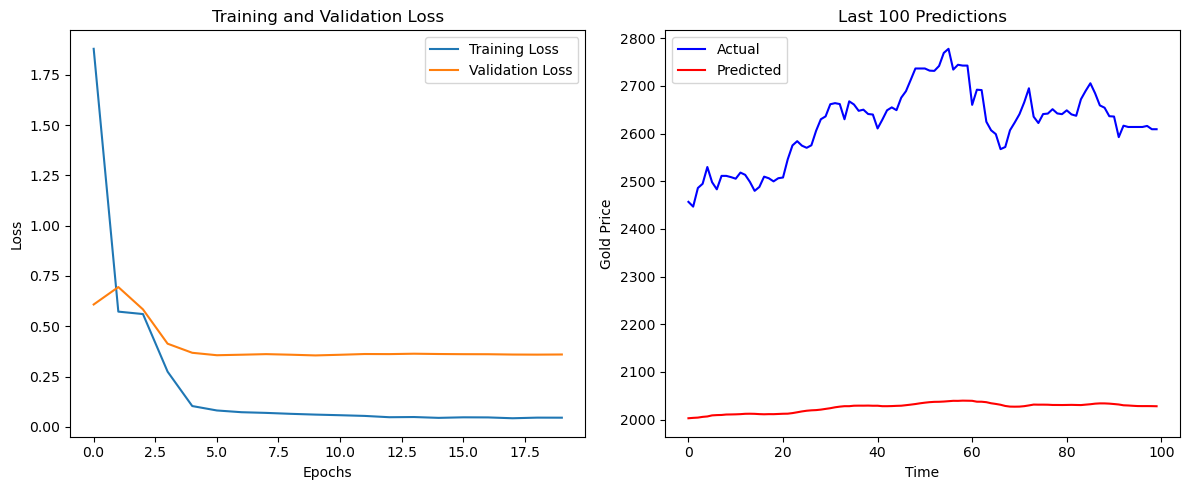


Analyzing feature importance...
44/44 [==============================] - 1s 14ms/step


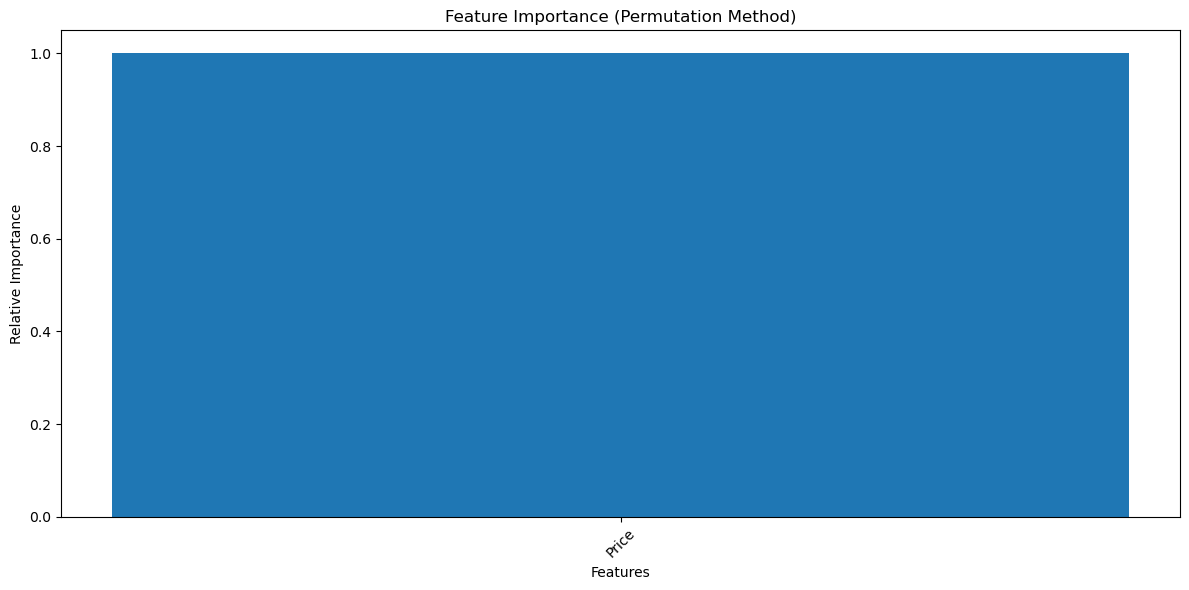


Visualizing attention over time...


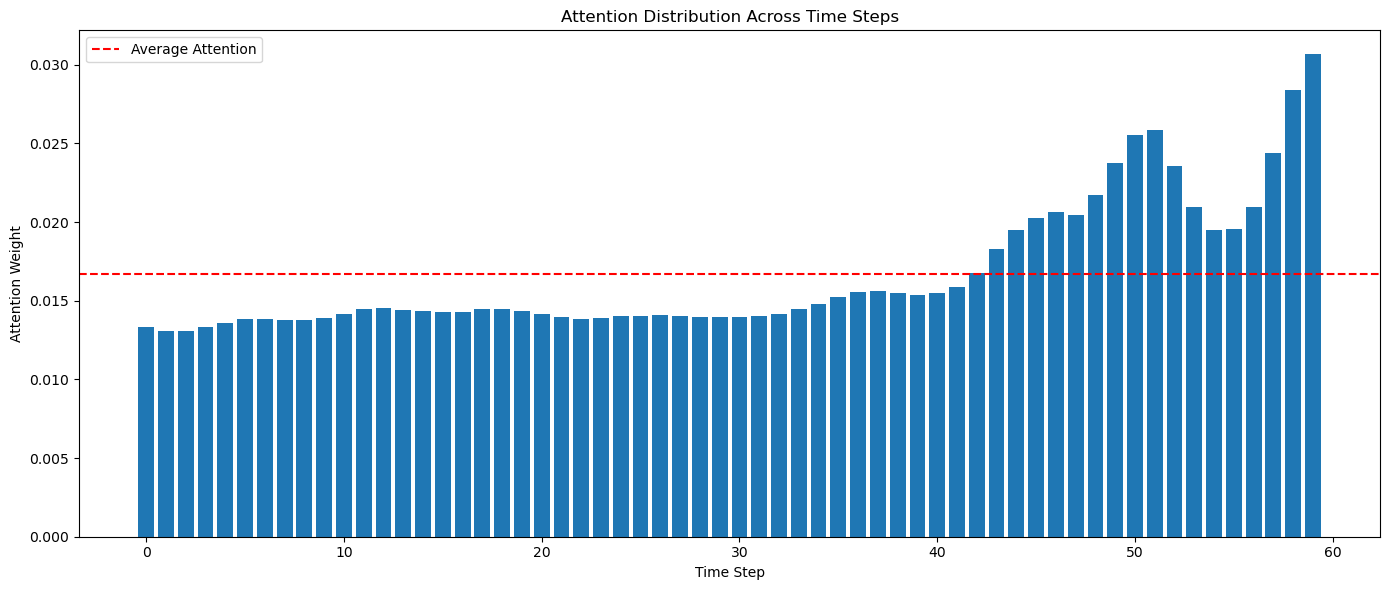

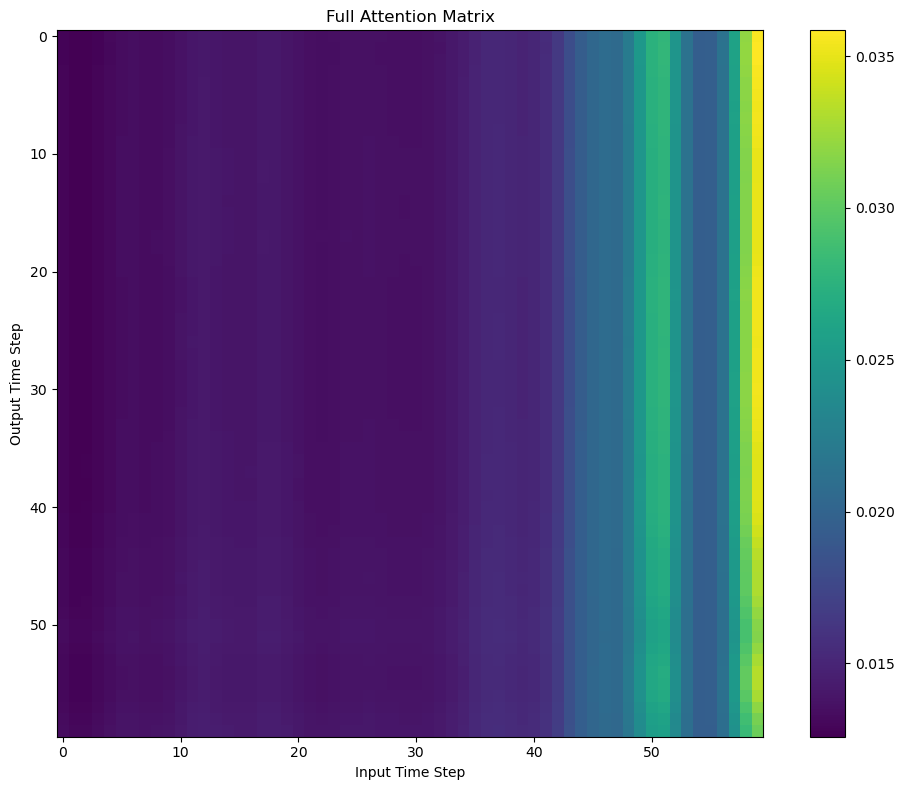


Running trading strategy backtest...


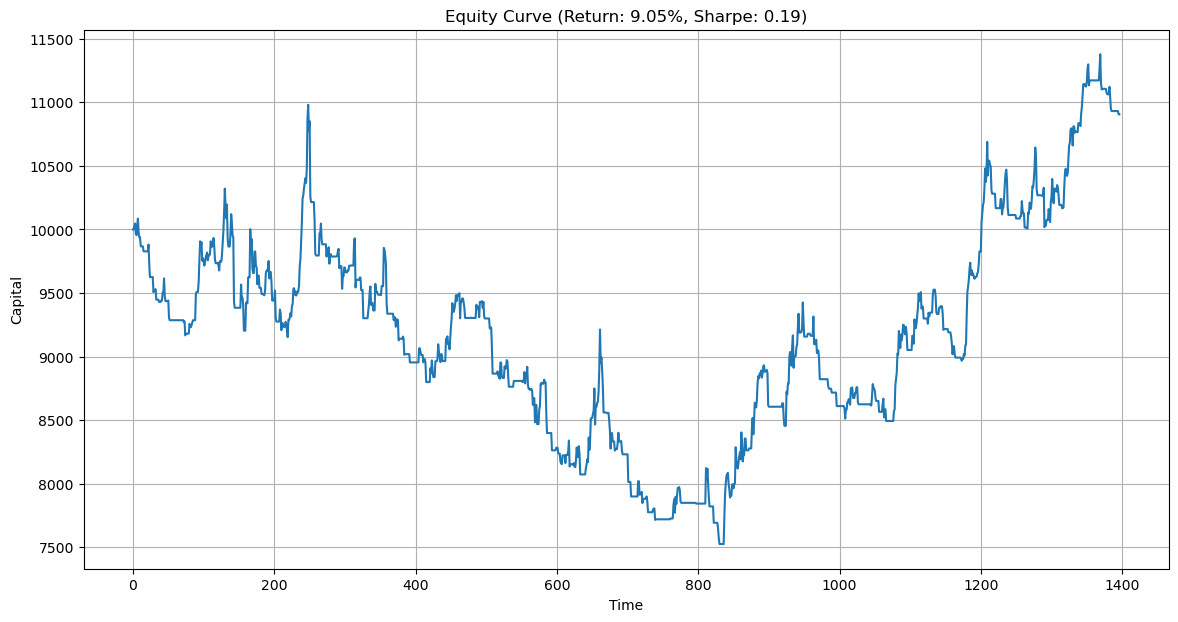

Final capital: $10905.15
Return: 9.05%
Sharpe Ratio: 0.19
Number of trades: 174
RMSE: 196.35
Directional Accuracy: 47.99%


In [42]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (5169, 60, 6)
Testing data shape: (1293, 60, 6)
Epoch 1/100
65/65 [==============================] - 8s 55ms/step - loss: 1.9454 - val_loss: 0.6294
Epoch 2/100
65/65 [==============================] - 3s 43ms/step - loss: 0.5848 - val_loss: 0.5256
Epoch 3/100
65/65 [==============================] - 3s 42ms/step - loss: 0.2128 - val_loss: 0.3651
Epoch 4/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0856 - val_loss: 0.3767
Epoch 5/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0663 - val_loss: 0.3710
Epoch 6/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0477 - val_loss: 0.3756
Epoch 7/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0464 - val_loss: 0.3652
Epoch 8/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0406 - val_loss: 0.3756
Epoch 9/100
65/65 [==============================] - 3s 41ms/step - loss: 0.0373 - val_loss: 0.3672
Epoch 10/100
65/65 [===========

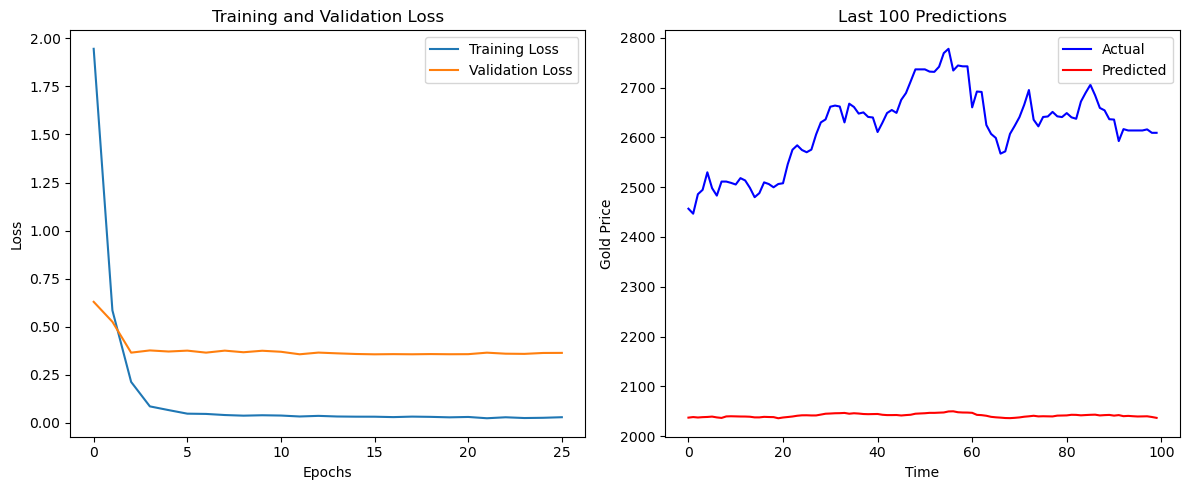


Analyzing feature importance...
41/41 [==============================] - 1s 14ms/step


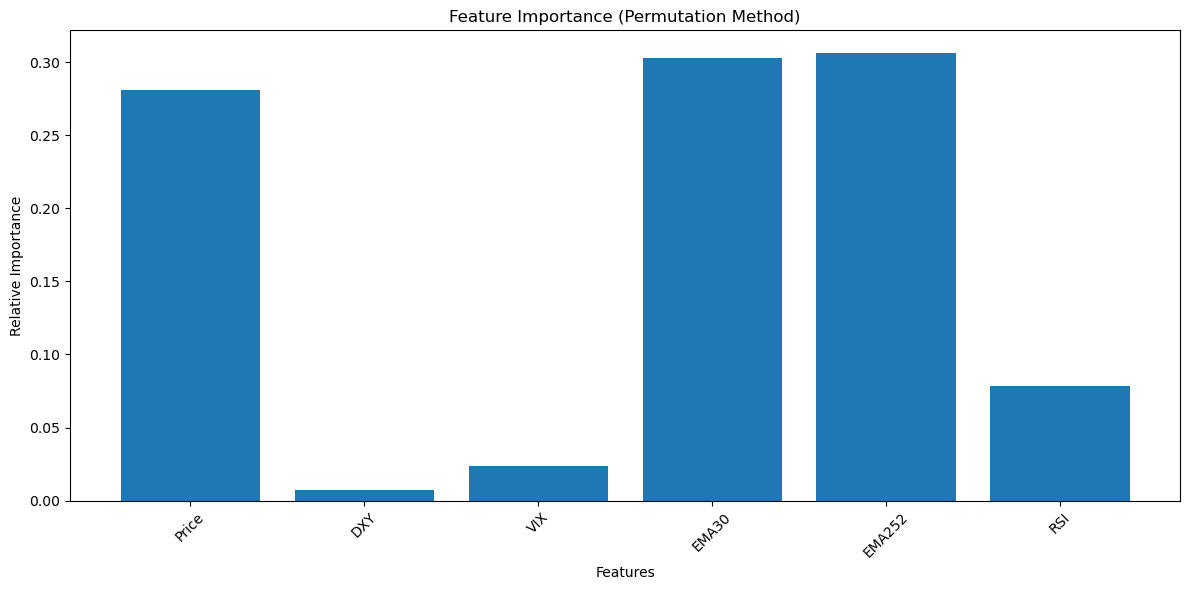


Visualizing attention over time...


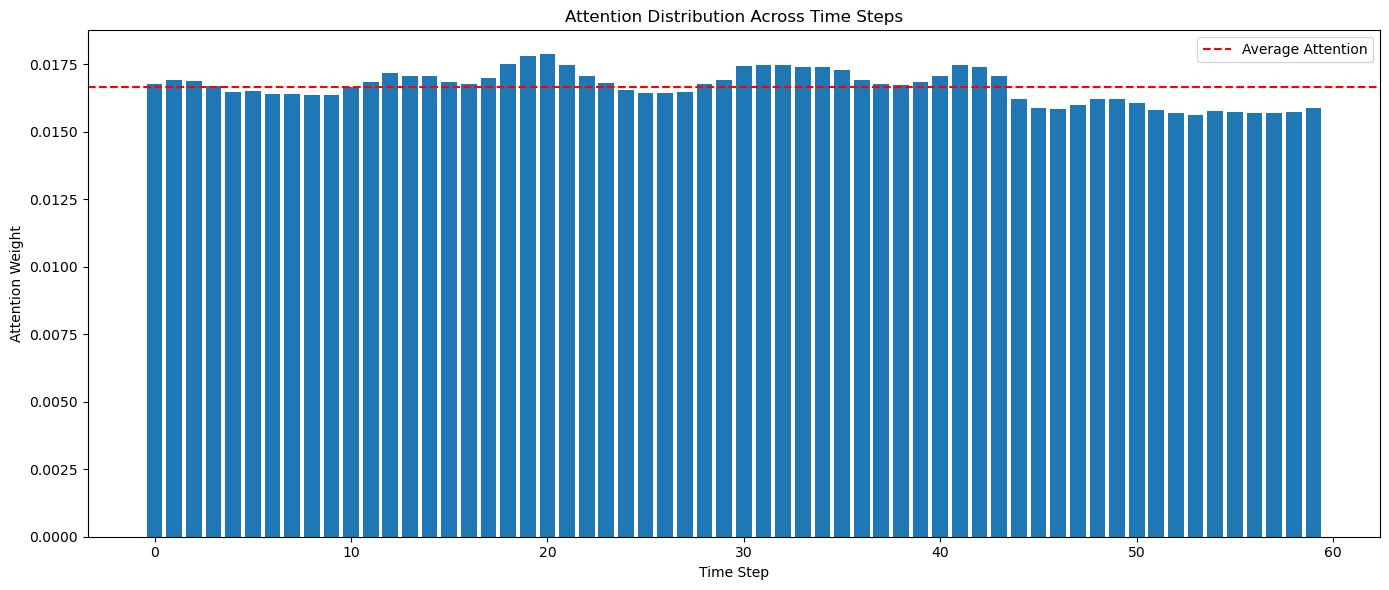

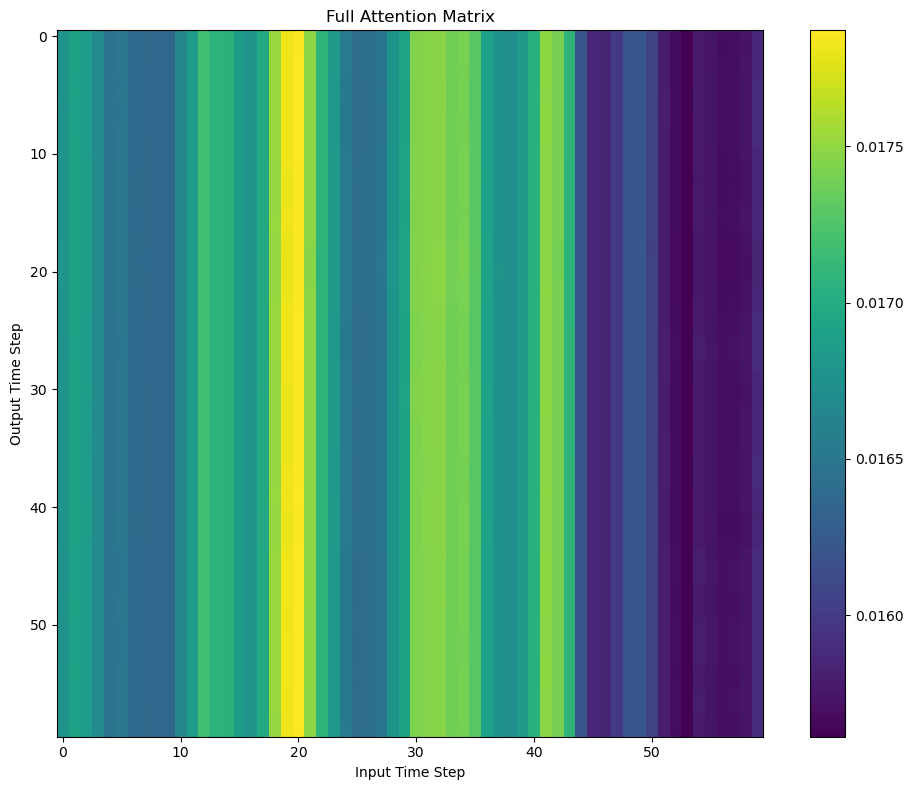


Running trading strategy backtest...


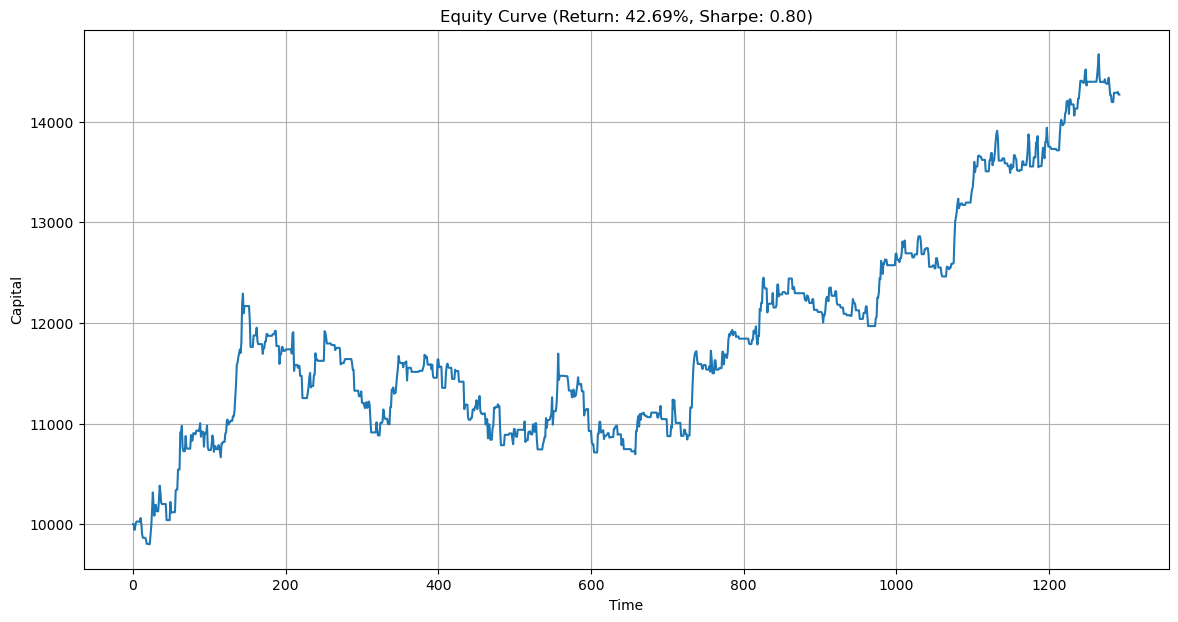

Final capital: $14269.20
Return: 42.69%
Sharpe Ratio: 0.80
Number of trades: 254
RMSE: 232.51
Directional Accuracy: 46.98%


In [43]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')

Training data shape: (3911, 60, 7)
Testing data shape: (978, 60, 7)
Epoch 1/100
49/49 [==============================] - 8s 60ms/step - loss: 2.6020 - val_loss: 1.0864
Epoch 2/100
49/49 [==============================] - 2s 43ms/step - loss: 0.6499 - val_loss: 1.1076
Epoch 3/100
49/49 [==============================] - 2s 43ms/step - loss: 0.5528 - val_loss: 0.7037
Epoch 4/100
49/49 [==============================] - 2s 42ms/step - loss: 0.1500 - val_loss: 0.4910
Epoch 5/100
49/49 [==============================] - 2s 42ms/step - loss: 0.1083 - val_loss: 0.4050
Epoch 6/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0920 - val_loss: 0.3966
Epoch 7/100
49/49 [==============================] - 2s 42ms/step - loss: 0.0763 - val_loss: 0.4433
Epoch 8/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0694 - val_loss: 0.3889
Epoch 9/100
49/49 [==============================] - 2s 41ms/step - loss: 0.0598 - val_loss: 0.4149
Epoch 10/100
49/49 [============

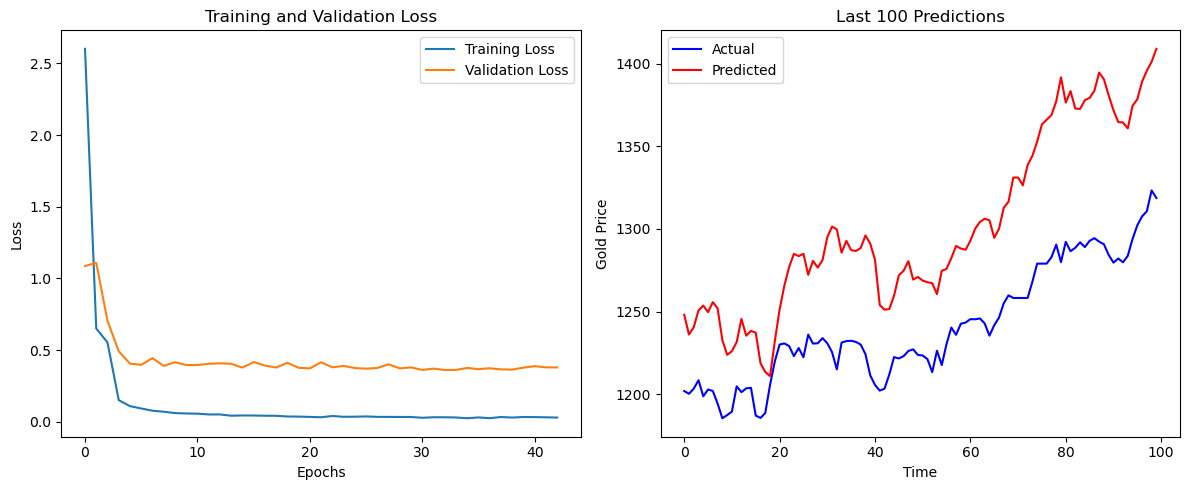


Analyzing feature importance...
31/31 [==============================] - 0s 14ms/step


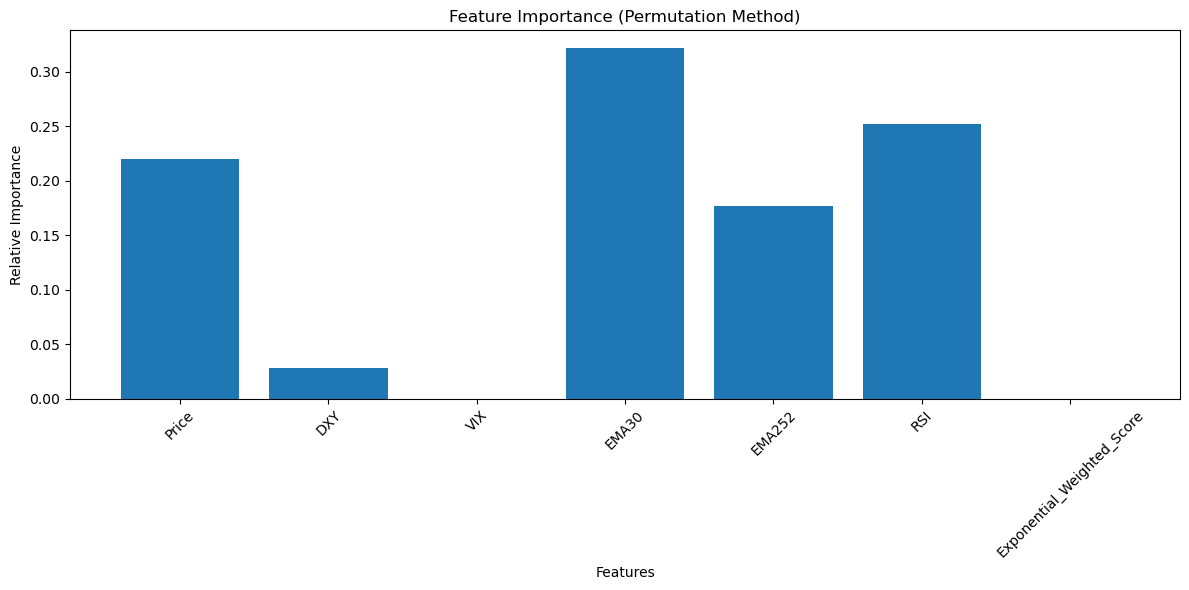


Visualizing attention over time...


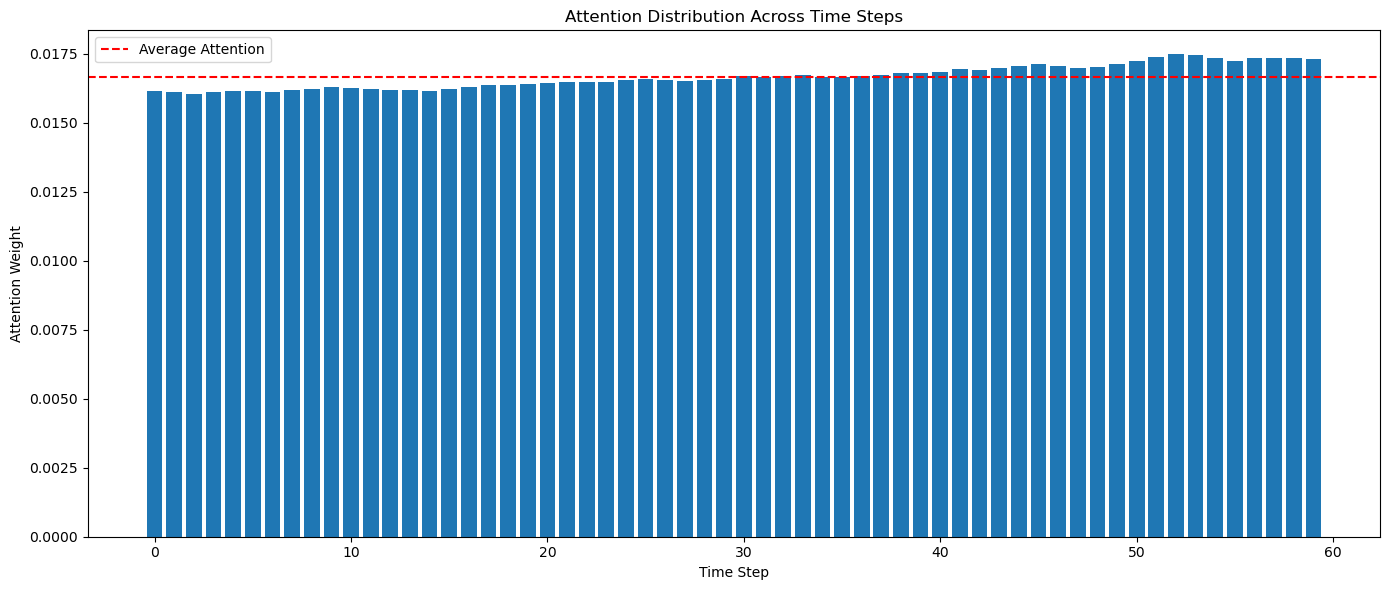

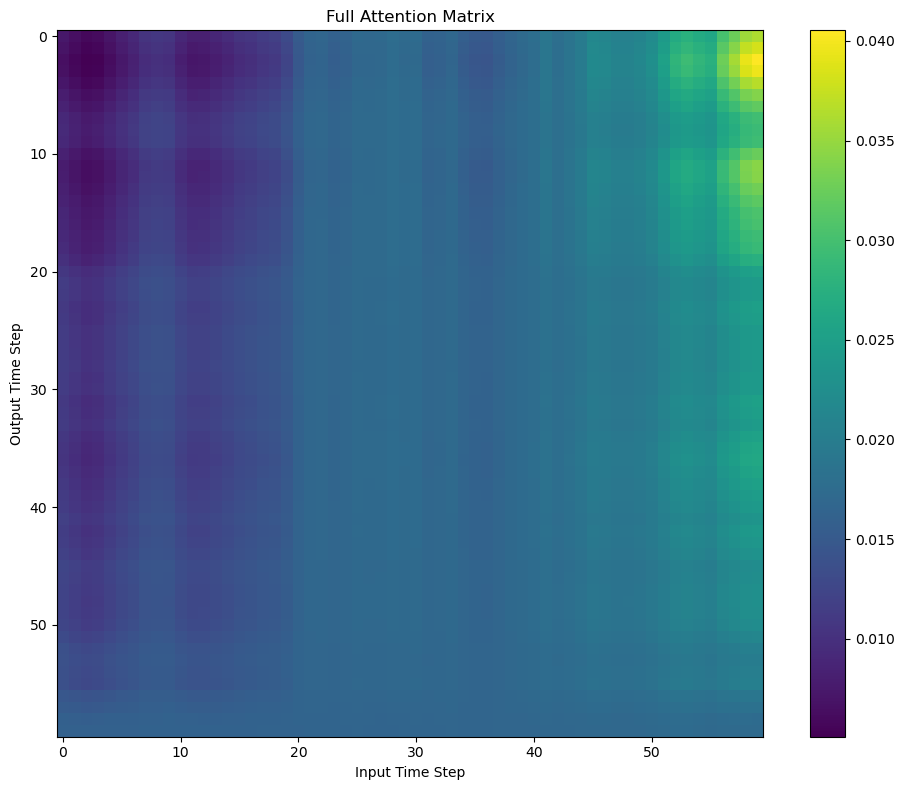


Running trading strategy backtest...


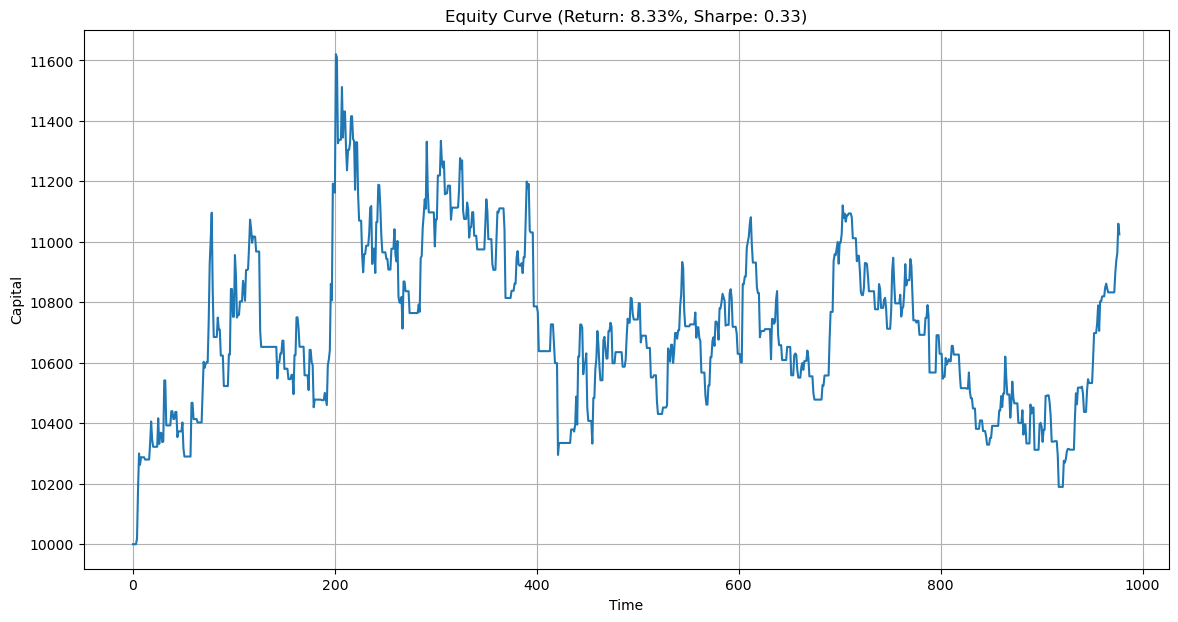

Final capital: $10832.81
Return: 8.33%
Sharpe Ratio: 0.33
Number of trades: 193
RMSE: 49.77
Directional Accuracy: 46.98%


In [44]:
df = load_data()

# Run the complete backtesting process
results = run_gold_price_backtesting(
    df,                     # Your dataframe with gold prices and features
    features = ["Price", "DXY", "VIX", "EMA30", "EMA252", "RSI", "Exponential_Weighted_Score"],
    seq_length=60,          # Length of sequence/window for predictions
    test_size=0.2,          # Proportion of data to use for testing
    d_model=256,            # Dimension of transformer model
    num_heads=8,            # Number of attention heads
    num_layers=4,           # Number of transformer layers
    dropout_rate=0.2,       # Dropout rate for regularization
    batch_size = 64,        # Batch size for training
    epochs=100,              # Maximum number of training epochs
    directional_loss_weight=0.7
)

# Access results
model = results['model']                   # The trained model
metrics = results['metrics']               # Performance metrics
feature_importance = results['feature_importance']  # Feature importance scores
trading_results = results['trading_results']        # Trading backtest results

# Print key metrics
print(f"RMSE: {metrics['rmse']:.2f}")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")

# Save model if needed
# model.save('gold_price_transformer.tf')